In [1]:
import math
import os
import random
import sys
import h5py
import logging
import numpy as np
from utils.data_utils import *
from models.motionpredictor import *
import torch
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt

/home/jaime/.conda/envs/torchy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {
    "learning_rate": 0.00001,
    "learning_rate_decay_factor": 0.95,
    "learning_rate_step": 10000,
    "batch_size": 128,
    "iterations": int(2e4),
    "kl_factor": 0.5
    "test_every": 100,
    "size": 512,
    "seq_length_in": 50,
    "seq_length_out": 25,
    # Directories
    "data_dir": os.path.normpath("../data/h3.6m/dataset"),
    "train_dir": os.path.normpath("../experiments/"),
    "action": 'all',
    "log_level": 20,
    "log_file": ''
}

In [3]:
train_dir = os.path.normpath(os.path.join( args['train_dir'], args['action'],
	'out_{0}'.format(args['seq_length_out']),
	'iterations_{0}'.format(args['iterations']),
	'size_{0}'.format(args['size']),
	'lr_{0}'.format(args['learning_rate'])))

In [4]:
args['seq_length_out'] # Number of frames that the decoder has to predict

25

In [5]:
# Logging
if args['log_file']=='':
	logging.basicConfig(format='%(levelname)s: %(message)s',level=args['log_level'])
else:
	logging.basicConfig(filename=args['log_file'],format='%(levelname)s: %(message)s',level=args['log_level'])

In [6]:
# Detect device
if torch.cuda.is_available():
	logging.info(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
	logging.info("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO: NVIDIA GeForce RTX 3090


In [7]:
logging.info("Train dir: "+train_dir)
os.makedirs(train_dir, exist_ok=True)

INFO: Train dir: ../experiments/all/out_25/iterations_20000/size_512/lr_1e-05


In [8]:
"""Train a seq2seq model on human motion"""
# Set of actions
actions           = define_actions( args['action'] ) # like "walking", "eating", "smoking", "discussion",  "directions", etc
number_of_actions = len( actions )

# Loads data for training/testing and normalizes it
# seq_length_in: number of frames to use in the burn-in sequence
# seq_length_out: number of frames to use in the output sequence
train_set, test_set, data_mean, data_std, dim_to_ignore, dim_to_use = read_all_data(actions, args['seq_length_in'], args['seq_length_out'], args['data_dir'])

INFO: Reading training data (seq_len_in: 50, seq_len_out 25).
INFO: Reading subject 1, action walking, subaction 1
INFO: Reading subject 1, action walking, subaction 2
INFO: Reading subject 1, action eating, subaction 1
INFO: Reading subject 1, action eating, subaction 2
INFO: Reading subject 1, action smoking, subaction 1
INFO: Reading subject 1, action smoking, subaction 2
INFO: Reading subject 1, action discussion, subaction 1
INFO: Reading subject 1, action discussion, subaction 2
INFO: Reading subject 1, action directions, subaction 1
INFO: Reading subject 1, action directions, subaction 2
INFO: Reading subject 1, action greeting, subaction 1
INFO: Reading subject 1, action greeting, subaction 2
INFO: Reading subject 1, action phoning, subaction 1
INFO: Reading subject 1, action phoning, subaction 2
INFO: Reading subject 1, action posing, subaction 1
INFO: Reading subject 1, action posing, subaction 2
INFO: Reading subject 1, action purchases, subaction 1
INFO: Reading subject 1, 

In [9]:
# Create model for training only
model = MotionPredictor(args['seq_length_in'], args['seq_length_out'],
    args['size'], # hidden layer size
    args['batch_size'], args['learning_rate'],
    args['learning_rate_decay_factor'],
    len( actions ))
model = model.to(device)

INFO: Input size is 69


In [10]:
model

MotionPredictor(
  (cell): GRUCell(69, 512)
  (fc1): Linear(in_features=512, out_features=69, bias=True)
  (fc_mean): Linear(in_features=512, out_features=512, bias=True)
  (fc_var): Linear(in_features=512, out_features=512, bias=True)
  (atten): Sequential(
    (0): Linear(in_features=581, out_features=512, bias=True)
    (1): Softmax(dim=1)
  )
)

In [11]:
# This is the training loop
loss, val_loss = 0.0, 0.0
current_step   = 0
all_losses     = []
all_val_losses = []

# The optimizer
#optimiser = optim.SGD(model.parameters(), lr=args.learning_rate)
optimiser = optim.Adam(model.parameters(), lr=args['learning_rate'], betas = (0.9, 0.999))

In [12]:
for _ in range(args['iterations']):
	optimiser.zero_grad()
	# Set a flag to compute gradients
	model.train()
	# === Training step ===

	# Get batch from the training set
	encoder_inputs, decoder_inputs, decoder_outputs = model.get_batch(train_set,actions,device)

	# Forward pass
	preds, mu, logvar = model(encoder_inputs, decoder_inputs,device)

	# Loss: Mean Squared Errors
	rec_loss = (preds-decoder_outputs)**2
	rec_loss = rec_loss.mean()
	kld_loss = -0.5 * (1 + logvar - mu**2 - torch.exp(logvar))
	kld_loss = torch.mean(torch.sum(kld_loss, axis=1))
	step_loss = kld_loss + rec_loss
	val_loss  = step_loss.mean()

	# step_loss = (preds-decoder_outputs)**2
	# step_loss = step_loss.mean()

	# Backpropagation
	step_loss.backward()
	# Gradient descent step
	optimiser.step()

	step_loss = step_loss.cpu().data.numpy()

	if current_step % 100 == 0:
		logging.info("step {0:04d}; step_loss: {1:.4f} ({2:.4f}, {3:.4f})".format(current_step, step_loss, rec_loss.cpu().data.numpy(), kld_loss.cpu().data.numpy()))
	loss += step_loss / args['test_every']
	current_step += 1
	# === step decay ===
	if current_step % args['learning_rate_step'] == 0:
		args['learning_rate'] = args['learning_rate']*args['learning_rate_decay_factor']
		optimiser = optim.Adam(model.parameters(),lr=args['learning_rate'], betas = (0.9, 0.999))
		print("Decay learning rate. New value at " + str(args['learning_rate']))

	# Once in a while, save checkpoint, print statistics.
	if current_step % args['test_every'] == 0:
		model.eval()
		# === Validation ===
		encoder_inputs, decoder_inputs, decoder_outputs = model.get_batch(test_set,actions,device)
		preds, mu, logvar = model(encoder_inputs, decoder_inputs, device)

		step_loss = (preds-decoder_outputs)**2
		# kld_loss =-0.5 * (1 + logvar - mu**2 - torch.exp(logvar))
		# step_loss = torch.mean(torch.sum(kld_loss, axis=1)) + rec_loss
		val_loss  = step_loss.mean()

		print("\n============================\n"
			"Global step:         %d\n"
			"Learning rate:       %.4f\n"
			"Train loss avg:      %.4f\n"
			"--------------------------\n"
			"Val loss:            %.4f\n"
			"============================\n" % (current_step,
			args['learning_rate'], loss,val_loss))
		all_val_losses.append([current_step,val_loss.cpu().detach().numpy()])
		all_losses.append([current_step,loss])
		torch.save(model, train_dir + '/model_' + str(current_step))
		# Reset loss
		loss = 0

INFO: step 0000; step_loss: 8.5086 (1.1799, 7.3286)
INFO: step 0100; step_loss: 7.5428 (0.9194, 6.6234)



Global step:         100
Learning rate:       0.0000
Train loss avg:      7.9074
--------------------------
Val loss:            0.9482



INFO: step 0200; step_loss: 5.6897 (0.6811, 5.0086)



Global step:         200
Learning rate:       0.0000
Train loss avg:      6.4343
--------------------------
Val loss:            0.7778



INFO: step 0300; step_loss: 4.9939 (0.5854, 4.4085)



Global step:         300
Learning rate:       0.0000
Train loss avg:      5.4470
--------------------------
Val loss:            0.6990



INFO: step 0400; step_loss: 4.1492 (0.5373, 3.6119)



Global step:         400
Learning rate:       0.0000
Train loss avg:      4.7007
--------------------------
Val loss:            0.5792



INFO: step 0500; step_loss: 4.3678 (0.5279, 3.8398)



Global step:         500
Learning rate:       0.0000
Train loss avg:      4.1683
--------------------------
Val loss:            0.5702



INFO: step 0600; step_loss: 3.4867 (0.4903, 2.9963)



Global step:         600
Learning rate:       0.0000
Train loss avg:      3.7229
--------------------------
Val loss:            0.4809



INFO: step 0700; step_loss: 2.8956 (0.3998, 2.4958)



Global step:         700
Learning rate:       0.0000
Train loss avg:      3.3041
--------------------------
Val loss:            0.5528



INFO: step 0800; step_loss: 3.1670 (0.4452, 2.7218)



Global step:         800
Learning rate:       0.0000
Train loss avg:      3.0430
--------------------------
Val loss:            0.5050



INFO: step 0900; step_loss: 2.6541 (0.4298, 2.2243)



Global step:         900
Learning rate:       0.0000
Train loss avg:      2.7465
--------------------------
Val loss:            0.4270



INFO: step 1000; step_loss: 2.2940 (0.3270, 1.9670)



Global step:         1000
Learning rate:       0.0000
Train loss avg:      2.5542
--------------------------
Val loss:            0.4743



INFO: step 1100; step_loss: 2.5268 (0.3901, 2.1368)



Global step:         1100
Learning rate:       0.0000
Train loss avg:      2.3476
--------------------------
Val loss:            0.4570



INFO: step 1200; step_loss: 2.2007 (0.4006, 1.8001)



Global step:         1200
Learning rate:       0.0000
Train loss avg:      2.2022
--------------------------
Val loss:            0.3842



INFO: step 1300; step_loss: 1.8705 (0.3341, 1.5364)



Global step:         1300
Learning rate:       0.0000
Train loss avg:      2.0516
--------------------------
Val loss:            0.4174



INFO: step 1400; step_loss: 1.8447 (0.3453, 1.4994)



Global step:         1400
Learning rate:       0.0000
Train loss avg:      1.9095
--------------------------
Val loss:            0.3925



INFO: step 1500; step_loss: 1.8359 (0.3759, 1.4601)



Global step:         1500
Learning rate:       0.0000
Train loss avg:      1.7833
--------------------------
Val loss:            0.3287



INFO: step 1600; step_loss: 1.5693 (0.3421, 1.2272)



Global step:         1600
Learning rate:       0.0000
Train loss avg:      1.7125
--------------------------
Val loss:            0.3154



INFO: step 1700; step_loss: 1.4906 (0.3095, 1.1811)



Global step:         1700
Learning rate:       0.0000
Train loss avg:      1.6090
--------------------------
Val loss:            0.3566



INFO: step 1800; step_loss: 1.5017 (0.3193, 1.1824)



Global step:         1800
Learning rate:       0.0000
Train loss avg:      1.5194
--------------------------
Val loss:            0.3262



INFO: step 1900; step_loss: 1.6451 (0.3678, 1.2773)



Global step:         1900
Learning rate:       0.0000
Train loss avg:      1.4232
--------------------------
Val loss:            0.3260



INFO: step 2000; step_loss: 1.3882 (0.3370, 1.0512)



Global step:         2000
Learning rate:       0.0000
Train loss avg:      1.3753
--------------------------
Val loss:            0.3439



INFO: step 2100; step_loss: 1.2106 (0.3208, 0.8899)



Global step:         2100
Learning rate:       0.0000
Train loss avg:      1.2881
--------------------------
Val loss:            0.3043



INFO: step 2200; step_loss: 1.2304 (0.3254, 0.9051)



Global step:         2200
Learning rate:       0.0000
Train loss avg:      1.2294
--------------------------
Val loss:            0.3209



INFO: step 2300; step_loss: 1.1468 (0.2623, 0.8845)



Global step:         2300
Learning rate:       0.0000
Train loss avg:      1.1726
--------------------------
Val loss:            0.3500



INFO: step 2400; step_loss: 1.1152 (0.2980, 0.8173)



Global step:         2400
Learning rate:       0.0000
Train loss avg:      1.1276
--------------------------
Val loss:            0.3405



INFO: step 2500; step_loss: 1.3168 (0.3963, 0.9204)



Global step:         2500
Learning rate:       0.0000
Train loss avg:      1.0776
--------------------------
Val loss:            0.3001



INFO: step 2600; step_loss: 0.9548 (0.2566, 0.6982)



Global step:         2600
Learning rate:       0.0000
Train loss avg:      1.0282
--------------------------
Val loss:            0.3325



INFO: step 2700; step_loss: 0.8698 (0.2371, 0.6327)



Global step:         2700
Learning rate:       0.0000
Train loss avg:      0.9917
--------------------------
Val loss:            0.3100



INFO: step 2800; step_loss: 0.9737 (0.2722, 0.7015)



Global step:         2800
Learning rate:       0.0000
Train loss avg:      0.9497
--------------------------
Val loss:            0.3082



INFO: step 2900; step_loss: 0.8771 (0.2729, 0.6041)



Global step:         2900
Learning rate:       0.0000
Train loss avg:      0.9247
--------------------------
Val loss:            0.2971



INFO: step 3000; step_loss: 0.8559 (0.2939, 0.5621)



Global step:         3000
Learning rate:       0.0000
Train loss avg:      0.8875
--------------------------
Val loss:            0.3134



INFO: step 3100; step_loss: 0.7778 (0.2660, 0.5118)



Global step:         3100
Learning rate:       0.0000
Train loss avg:      0.8544
--------------------------
Val loss:            0.3215



INFO: step 3200; step_loss: 0.7402 (0.2379, 0.5022)



Global step:         3200
Learning rate:       0.0000
Train loss avg:      0.8091
--------------------------
Val loss:            0.3099



INFO: step 3300; step_loss: 0.8208 (0.3145, 0.5063)



Global step:         3300
Learning rate:       0.0000
Train loss avg:      0.7877
--------------------------
Val loss:            0.2857



INFO: step 3400; step_loss: 0.7510 (0.2657, 0.4853)



Global step:         3400
Learning rate:       0.0000
Train loss avg:      0.7565
--------------------------
Val loss:            0.3213



INFO: step 3500; step_loss: 0.6800 (0.2703, 0.4097)



Global step:         3500
Learning rate:       0.0000
Train loss avg:      0.7368
--------------------------
Val loss:            0.2765



INFO: step 3600; step_loss: 0.6924 (0.2718, 0.4206)



Global step:         3600
Learning rate:       0.0000
Train loss avg:      0.7245
--------------------------
Val loss:            0.2490



INFO: step 3700; step_loss: 0.7140 (0.2969, 0.4171)



Global step:         3700
Learning rate:       0.0000
Train loss avg:      0.6905
--------------------------
Val loss:            0.2957



INFO: step 3800; step_loss: 0.6247 (0.2605, 0.3642)



Global step:         3800
Learning rate:       0.0000
Train loss avg:      0.6789
--------------------------
Val loss:            0.3168



INFO: step 3900; step_loss: 0.7482 (0.3441, 0.4041)



Global step:         3900
Learning rate:       0.0000
Train loss avg:      0.6612
--------------------------
Val loss:            0.3050



INFO: step 4000; step_loss: 0.5725 (0.2435, 0.3290)



Global step:         4000
Learning rate:       0.0000
Train loss avg:      0.6354
--------------------------
Val loss:            0.3069



INFO: step 4100; step_loss: 0.5728 (0.2373, 0.3355)



Global step:         4100
Learning rate:       0.0000
Train loss avg:      0.6179
--------------------------
Val loss:            0.3228



INFO: step 4200; step_loss: 0.6224 (0.3041, 0.3183)



Global step:         4200
Learning rate:       0.0000
Train loss avg:      0.6024
--------------------------
Val loss:            0.2739



INFO: step 4300; step_loss: 0.5526 (0.2611, 0.2915)



Global step:         4300
Learning rate:       0.0000
Train loss avg:      0.5702
--------------------------
Val loss:            0.3065



INFO: step 4400; step_loss: 0.5629 (0.2753, 0.2876)



Global step:         4400
Learning rate:       0.0000
Train loss avg:      0.5723
--------------------------
Val loss:            0.2934



INFO: step 4500; step_loss: 0.5661 (0.3013, 0.2648)



Global step:         4500
Learning rate:       0.0000
Train loss avg:      0.5484
--------------------------
Val loss:            0.2693



INFO: step 4600; step_loss: 0.5449 (0.2589, 0.2861)



Global step:         4600
Learning rate:       0.0000
Train loss avg:      0.5408
--------------------------
Val loss:            0.2701



INFO: step 4700; step_loss: 0.4728 (0.2339, 0.2389)



Global step:         4700
Learning rate:       0.0000
Train loss avg:      0.5241
--------------------------
Val loss:            0.2677



INFO: step 4800; step_loss: 0.4146 (0.1972, 0.2174)



Global step:         4800
Learning rate:       0.0000
Train loss avg:      0.5064
--------------------------
Val loss:            0.2946



INFO: step 4900; step_loss: 0.5023 (0.2684, 0.2339)



Global step:         4900
Learning rate:       0.0000
Train loss avg:      0.4977
--------------------------
Val loss:            0.2496



INFO: step 5000; step_loss: 0.4462 (0.2467, 0.1995)



Global step:         5000
Learning rate:       0.0000
Train loss avg:      0.4831
--------------------------
Val loss:            0.3358



INFO: step 5100; step_loss: 0.4766 (0.2730, 0.2037)



Global step:         5100
Learning rate:       0.0000
Train loss avg:      0.4696
--------------------------
Val loss:            0.2737



INFO: step 5200; step_loss: 0.4545 (0.2681, 0.1863)



Global step:         5200
Learning rate:       0.0000
Train loss avg:      0.4693
--------------------------
Val loss:            0.2393



INFO: step 5300; step_loss: 0.3915 (0.2309, 0.1607)



Global step:         5300
Learning rate:       0.0000
Train loss avg:      0.4599
--------------------------
Val loss:            0.2474



INFO: step 5400; step_loss: 0.3827 (0.2205, 0.1622)



Global step:         5400
Learning rate:       0.0000
Train loss avg:      0.4392
--------------------------
Val loss:            0.3202



INFO: step 5500; step_loss: 0.4524 (0.2956, 0.1568)



Global step:         5500
Learning rate:       0.0000
Train loss avg:      0.4239
--------------------------
Val loss:            0.2815



INFO: step 5600; step_loss: 0.3723 (0.2130, 0.1593)



Global step:         5600
Learning rate:       0.0000
Train loss avg:      0.4268
--------------------------
Val loss:            0.2873



INFO: step 5700; step_loss: 0.3666 (0.2196, 0.1470)



Global step:         5700
Learning rate:       0.0000
Train loss avg:      0.4209
--------------------------
Val loss:            0.2965



INFO: step 5800; step_loss: 0.3851 (0.2219, 0.1632)



Global step:         5800
Learning rate:       0.0000
Train loss avg:      0.4204
--------------------------
Val loss:            0.3055



INFO: step 5900; step_loss: 0.3674 (0.2458, 0.1216)



Global step:         5900
Learning rate:       0.0000
Train loss avg:      0.4057
--------------------------
Val loss:            0.2982



INFO: step 6000; step_loss: 0.4724 (0.3332, 0.1392)



Global step:         6000
Learning rate:       0.0000
Train loss avg:      0.3922
--------------------------
Val loss:            0.2583



INFO: step 6100; step_loss: 0.3205 (0.2072, 0.1133)



Global step:         6100
Learning rate:       0.0000
Train loss avg:      0.3847
--------------------------
Val loss:            0.2582



INFO: step 6200; step_loss: 0.5057 (0.3544, 0.1513)



Global step:         6200
Learning rate:       0.0000
Train loss avg:      0.3768
--------------------------
Val loss:            0.3062



INFO: step 6300; step_loss: 0.3009 (0.2002, 0.1006)



Global step:         6300
Learning rate:       0.0000
Train loss avg:      0.3772
--------------------------
Val loss:            0.2734



INFO: step 6400; step_loss: 0.3316 (0.2370, 0.0946)



Global step:         6400
Learning rate:       0.0000
Train loss avg:      0.3704
--------------------------
Val loss:            0.2996



INFO: step 6500; step_loss: 0.3761 (0.2662, 0.1099)



Global step:         6500
Learning rate:       0.0000
Train loss avg:      0.3625
--------------------------
Val loss:            0.3140



INFO: step 6600; step_loss: 0.3003 (0.2136, 0.0867)



Global step:         6600
Learning rate:       0.0000
Train loss avg:      0.3605
--------------------------
Val loss:            0.2502



INFO: step 6700; step_loss: 0.3379 (0.2344, 0.1036)



Global step:         6700
Learning rate:       0.0000
Train loss avg:      0.3557
--------------------------
Val loss:            0.2934



INFO: step 6800; step_loss: 0.3261 (0.2385, 0.0877)



Global step:         6800
Learning rate:       0.0000
Train loss avg:      0.3503
--------------------------
Val loss:            0.2910



INFO: step 6900; step_loss: 0.3161 (0.2317, 0.0844)



Global step:         6900
Learning rate:       0.0000
Train loss avg:      0.3406
--------------------------
Val loss:            0.3185



INFO: step 7000; step_loss: 0.3060 (0.2303, 0.0757)



Global step:         7000
Learning rate:       0.0000
Train loss avg:      0.3434
--------------------------
Val loss:            0.2660



INFO: step 7100; step_loss: 0.4249 (0.3312, 0.0937)



Global step:         7100
Learning rate:       0.0000
Train loss avg:      0.3361
--------------------------
Val loss:            0.2905



INFO: step 7200; step_loss: 0.3367 (0.2538, 0.0829)



Global step:         7200
Learning rate:       0.0000
Train loss avg:      0.3382
--------------------------
Val loss:            0.3015



INFO: step 7300; step_loss: 0.3284 (0.2488, 0.0795)



Global step:         7300
Learning rate:       0.0000
Train loss avg:      0.3328
--------------------------
Val loss:            0.2764



INFO: step 7400; step_loss: 0.3224 (0.2538, 0.0686)



Global step:         7400
Learning rate:       0.0000
Train loss avg:      0.3296
--------------------------
Val loss:            0.3060



INFO: step 7500; step_loss: 0.2813 (0.2211, 0.0602)



Global step:         7500
Learning rate:       0.0000
Train loss avg:      0.3244
--------------------------
Val loss:            0.3083



INFO: step 7600; step_loss: 0.3061 (0.2381, 0.0680)



Global step:         7600
Learning rate:       0.0000
Train loss avg:      0.3261
--------------------------
Val loss:            0.2939



INFO: step 7700; step_loss: 0.3103 (0.2466, 0.0637)



Global step:         7700
Learning rate:       0.0000
Train loss avg:      0.3172
--------------------------
Val loss:            0.2746



INFO: step 7800; step_loss: 0.3307 (0.2656, 0.0651)



Global step:         7800
Learning rate:       0.0000
Train loss avg:      0.3118
--------------------------
Val loss:            0.3387



INFO: step 7900; step_loss: 0.3214 (0.2624, 0.0591)



Global step:         7900
Learning rate:       0.0000
Train loss avg:      0.3099
--------------------------
Val loss:            0.2647



INFO: step 8000; step_loss: 0.2605 (0.2109, 0.0497)



Global step:         8000
Learning rate:       0.0000
Train loss avg:      0.3103
--------------------------
Val loss:            0.3015



INFO: step 8100; step_loss: 0.3258 (0.2671, 0.0586)



Global step:         8100
Learning rate:       0.0000
Train loss avg:      0.3051
--------------------------
Val loss:            0.2717



INFO: step 8200; step_loss: 0.2511 (0.2039, 0.0472)



Global step:         8200
Learning rate:       0.0000
Train loss avg:      0.2994
--------------------------
Val loss:            0.3006



INFO: step 8300; step_loss: 0.3371 (0.2759, 0.0612)



Global step:         8300
Learning rate:       0.0000
Train loss avg:      0.2995
--------------------------
Val loss:            0.2530



INFO: step 8400; step_loss: 0.2657 (0.2191, 0.0465)



Global step:         8400
Learning rate:       0.0000
Train loss avg:      0.3012
--------------------------
Val loss:            0.2989



INFO: step 8500; step_loss: 0.2998 (0.2545, 0.0453)



Global step:         8500
Learning rate:       0.0000
Train loss avg:      0.2961
--------------------------
Val loss:            0.2879



INFO: step 8600; step_loss: 0.2625 (0.2259, 0.0365)



Global step:         8600
Learning rate:       0.0000
Train loss avg:      0.2935
--------------------------
Val loss:            0.3118



INFO: step 8700; step_loss: 0.2876 (0.2457, 0.0419)



Global step:         8700
Learning rate:       0.0000
Train loss avg:      0.2967
--------------------------
Val loss:            0.2779



INFO: step 8800; step_loss: 0.2313 (0.1955, 0.0357)



Global step:         8800
Learning rate:       0.0000
Train loss avg:      0.2927
--------------------------
Val loss:            0.2747



INFO: step 8900; step_loss: 0.2838 (0.2351, 0.0487)



Global step:         8900
Learning rate:       0.0000
Train loss avg:      0.2912
--------------------------
Val loss:            0.2739



INFO: step 9000; step_loss: 0.2574 (0.2219, 0.0355)



Global step:         9000
Learning rate:       0.0000
Train loss avg:      0.2837
--------------------------
Val loss:            0.2830



INFO: step 9100; step_loss: 0.2643 (0.2323, 0.0320)



Global step:         9100
Learning rate:       0.0000
Train loss avg:      0.2841
--------------------------
Val loss:            0.2605



INFO: step 9200; step_loss: 0.2631 (0.2333, 0.0299)



Global step:         9200
Learning rate:       0.0000
Train loss avg:      0.2793
--------------------------
Val loss:            0.2661



INFO: step 9300; step_loss: 0.2259 (0.1949, 0.0310)



Global step:         9300
Learning rate:       0.0000
Train loss avg:      0.2839
--------------------------
Val loss:            0.3206


Global step:         9400
Learning rate:       0.0000
Train loss avg:      0.2855
--------------------------
Val loss:            0.3032



INFO: step 9400; step_loss: 0.2663 (0.2366, 0.0297)
INFO: step 9500; step_loss: 0.2779 (0.2471, 0.0307)



Global step:         9500
Learning rate:       0.0000
Train loss avg:      0.2820
--------------------------
Val loss:            0.2990



INFO: step 9600; step_loss: 0.3386 (0.3119, 0.0266)



Global step:         9600
Learning rate:       0.0000
Train loss avg:      0.2794
--------------------------
Val loss:            0.2482


Global step:         9700
Learning rate:       0.0000
Train loss avg:      0.2723
--------------------------
Val loss:            0.3041



INFO: step 9700; step_loss: 0.2829 (0.2498, 0.0331)



Global step:         9800
Learning rate:       0.0000
Train loss avg:      0.2741
--------------------------
Val loss:            0.2984



INFO: step 9800; step_loss: 0.2453 (0.2196, 0.0256)
INFO: step 9900; step_loss: 0.2718 (0.2449, 0.0270)



Global step:         9900
Learning rate:       0.0000
Train loss avg:      0.2724
--------------------------
Val loss:            0.2887



INFO: step 10000; step_loss: 0.2633 (0.2386, 0.0246)


Decay learning rate. New value at 9.5e-06

Global step:         10000
Learning rate:       0.0000
Train loss avg:      0.2692
--------------------------
Val loss:            0.3042



INFO: step 10100; step_loss: 0.3393 (0.3139, 0.0255)



Global step:         10100
Learning rate:       0.0000
Train loss avg:      0.2747
--------------------------
Val loss:            0.2961



INFO: step 10200; step_loss: 0.2450 (0.2229, 0.0220)



Global step:         10200
Learning rate:       0.0000
Train loss avg:      0.2638
--------------------------
Val loss:            0.2779


Global step:         10300
Learning rate:       0.0000
Train loss avg:      0.2714
--------------------------
Val loss:            0.3054



INFO: step 10300; step_loss: 0.3218 (0.2993, 0.0224)
INFO: step 10400; step_loss: 0.3684 (0.3428, 0.0256)



Global step:         10400
Learning rate:       0.0000
Train loss avg:      0.2669
--------------------------
Val loss:            0.2704



INFO: step 10500; step_loss: 0.2395 (0.2229, 0.0166)



Global step:         10500
Learning rate:       0.0000
Train loss avg:      0.2667
--------------------------
Val loss:            0.2817



INFO: step 10600; step_loss: 0.2364 (0.2183, 0.0181)



Global step:         10600
Learning rate:       0.0000
Train loss avg:      0.2706
--------------------------
Val loss:            0.2900



INFO: step 10700; step_loss: 0.2657 (0.2492, 0.0165)



Global step:         10700
Learning rate:       0.0000
Train loss avg:      0.2645
--------------------------
Val loss:            0.2979



INFO: step 10800; step_loss: 0.3147 (0.2967, 0.0181)



Global step:         10800
Learning rate:       0.0000
Train loss avg:      0.2628
--------------------------
Val loss:            0.2348



INFO: step 10900; step_loss: 0.3333 (0.3148, 0.0185)



Global step:         10900
Learning rate:       0.0000
Train loss avg:      0.2590
--------------------------
Val loss:            0.2584



INFO: step 11000; step_loss: 0.2493 (0.2355, 0.0138)



Global step:         11000
Learning rate:       0.0000
Train loss avg:      0.2637
--------------------------
Val loss:            0.2946



INFO: step 11100; step_loss: 0.3048 (0.2909, 0.0140)



Global step:         11100
Learning rate:       0.0000
Train loss avg:      0.2624
--------------------------
Val loss:            0.2688



INFO: step 11200; step_loss: 0.2937 (0.2761, 0.0176)



Global step:         11200
Learning rate:       0.0000
Train loss avg:      0.2613
--------------------------
Val loss:            0.2844


Global step:         11300
Learning rate:       0.0000
Train loss avg:      0.2594
--------------------------
Val loss:            0.2741



INFO: step 11300; step_loss: 0.3442 (0.3286, 0.0157)
INFO: step 11400; step_loss: 0.3046 (0.2897, 0.0149)



Global step:         11400
Learning rate:       0.0000
Train loss avg:      0.2601
--------------------------
Val loss:            0.2866



INFO: step 11500; step_loss: 0.2470 (0.2314, 0.0156)



Global step:         11500
Learning rate:       0.0000
Train loss avg:      0.2642
--------------------------
Val loss:            0.2956



INFO: step 11600; step_loss: 0.2792 (0.2652, 0.0140)



Global step:         11600
Learning rate:       0.0000
Train loss avg:      0.2551
--------------------------
Val loss:            0.2630



INFO: step 11700; step_loss: 0.2366 (0.2259, 0.0107)



Global step:         11700
Learning rate:       0.0000
Train loss avg:      0.2580
--------------------------
Val loss:            0.2802



INFO: step 11800; step_loss: 0.2538 (0.2433, 0.0105)



Global step:         11800
Learning rate:       0.0000
Train loss avg:      0.2595
--------------------------
Val loss:            0.2777



INFO: step 11900; step_loss: 0.3002 (0.2885, 0.0116)



Global step:         11900
Learning rate:       0.0000
Train loss avg:      0.2535
--------------------------
Val loss:            0.2828


Global step:         12000
Learning rate:       0.0000
Train loss avg:      0.2554
--------------------------
Val loss:            0.2896



INFO: step 12000; step_loss: 0.2042 (0.1944, 0.0098)



Global step:         12100
Learning rate:       0.0000
Train loss avg:      0.2517
--------------------------
Val loss:            0.2671



INFO: step 12100; step_loss: 0.2233 (0.2150, 0.0082)
INFO: step 12200; step_loss: 0.2731 (0.2644, 0.0088)



Global step:         12200
Learning rate:       0.0000
Train loss avg:      0.2477
--------------------------
Val loss:            0.3066



INFO: step 12300; step_loss: 0.2340 (0.2257, 0.0083)



Global step:         12300
Learning rate:       0.0000
Train loss avg:      0.2548
--------------------------
Val loss:            0.3298



INFO: step 12400; step_loss: 0.2136 (0.2065, 0.0071)



Global step:         12400
Learning rate:       0.0000
Train loss avg:      0.2540
--------------------------
Val loss:            0.2744



INFO: step 12500; step_loss: 0.2353 (0.2282, 0.0071)



Global step:         12500
Learning rate:       0.0000
Train loss avg:      0.2492
--------------------------
Val loss:            0.2937



INFO: step 12600; step_loss: 0.2419 (0.2345, 0.0075)



Global step:         12600
Learning rate:       0.0000
Train loss avg:      0.2511
--------------------------
Val loss:            0.2761



INFO: step 12700; step_loss: 0.2552 (0.2481, 0.0071)



Global step:         12700
Learning rate:       0.0000
Train loss avg:      0.2481
--------------------------
Val loss:            0.3220



INFO: step 12800; step_loss: 0.2285 (0.2218, 0.0066)



Global step:         12800
Learning rate:       0.0000
Train loss avg:      0.2461
--------------------------
Val loss:            0.2694



INFO: step 12900; step_loss: 0.2582 (0.2521, 0.0061)



Global step:         12900
Learning rate:       0.0000
Train loss avg:      0.2504
--------------------------
Val loss:            0.2651



INFO: step 13000; step_loss: 0.2187 (0.2120, 0.0067)



Global step:         13000
Learning rate:       0.0000
Train loss avg:      0.2486
--------------------------
Val loss:            0.2918



INFO: step 13100; step_loss: 0.2256 (0.2181, 0.0075)



Global step:         13100
Learning rate:       0.0000
Train loss avg:      0.2474
--------------------------
Val loss:            0.2486



INFO: step 13200; step_loss: 0.2310 (0.2251, 0.0059)



Global step:         13200
Learning rate:       0.0000
Train loss avg:      0.2510
--------------------------
Val loss:            0.2949



INFO: step 13300; step_loss: 0.2310 (0.2254, 0.0057)



Global step:         13300
Learning rate:       0.0000
Train loss avg:      0.2470
--------------------------
Val loss:            0.2612


Global step:         13400
Learning rate:       0.0000
Train loss avg:      0.2465
--------------------------
Val loss:            0.2860



INFO: step 13400; step_loss: 0.2165 (0.2110, 0.0055)
INFO: step 13500; step_loss: 0.2657 (0.2597, 0.0060)



Global step:         13500
Learning rate:       0.0000
Train loss avg:      0.2461
--------------------------
Val loss:            0.3031



INFO: step 13600; step_loss: 0.2310 (0.2259, 0.0051)



Global step:         13600
Learning rate:       0.0000
Train loss avg:      0.2446
--------------------------
Val loss:            0.2588



INFO: step 13700; step_loss: 0.2574 (0.2523, 0.0050)



Global step:         13700
Learning rate:       0.0000
Train loss avg:      0.2472
--------------------------
Val loss:            0.2569



INFO: step 13800; step_loss: 0.2444 (0.2396, 0.0048)



Global step:         13800
Learning rate:       0.0000
Train loss avg:      0.2461
--------------------------
Val loss:            0.2993



INFO: step 13900; step_loss: 0.2021 (0.1982, 0.0039)



Global step:         13900
Learning rate:       0.0000
Train loss avg:      0.2483
--------------------------
Val loss:            0.2922



INFO: step 14000; step_loss: 0.2144 (0.2098, 0.0046)



Global step:         14000
Learning rate:       0.0000
Train loss avg:      0.2473
--------------------------
Val loss:            0.3005



INFO: step 14100; step_loss: 0.2457 (0.2415, 0.0043)



Global step:         14100
Learning rate:       0.0000
Train loss avg:      0.2428
--------------------------
Val loss:            0.2811



INFO: step 14200; step_loss: 0.2729 (0.2680, 0.0050)



Global step:         14200
Learning rate:       0.0000
Train loss avg:      0.2497
--------------------------
Val loss:            0.2662



INFO: step 14300; step_loss: 0.2217 (0.2182, 0.0035)



Global step:         14300
Learning rate:       0.0000
Train loss avg:      0.2451
--------------------------
Val loss:            0.2867



INFO: step 14400; step_loss: 0.2436 (0.2385, 0.0051)



Global step:         14400
Learning rate:       0.0000
Train loss avg:      0.2434
--------------------------
Val loss:            0.2720



INFO: step 14500; step_loss: 0.2775 (0.2740, 0.0035)



Global step:         14500
Learning rate:       0.0000
Train loss avg:      0.2446
--------------------------
Val loss:            0.2553



INFO: step 14600; step_loss: 0.2445 (0.2413, 0.0032)



Global step:         14600
Learning rate:       0.0000
Train loss avg:      0.2439
--------------------------
Val loss:            0.2683



INFO: step 14700; step_loss: 0.2496 (0.2464, 0.0032)



Global step:         14700
Learning rate:       0.0000
Train loss avg:      0.2415
--------------------------
Val loss:            0.2461



INFO: step 14800; step_loss: 0.2388 (0.2361, 0.0027)



Global step:         14800
Learning rate:       0.0000
Train loss avg:      0.2457
--------------------------
Val loss:            0.3092



INFO: step 14900; step_loss: 0.1879 (0.1854, 0.0025)



Global step:         14900
Learning rate:       0.0000
Train loss avg:      0.2454
--------------------------
Val loss:            0.2828



INFO: step 15000; step_loss: 0.2335 (0.2309, 0.0026)



Global step:         15000
Learning rate:       0.0000
Train loss avg:      0.2406
--------------------------
Val loss:            0.3001



INFO: step 15100; step_loss: 0.2089 (0.2064, 0.0025)



Global step:         15100
Learning rate:       0.0000
Train loss avg:      0.2424
--------------------------
Val loss:            0.2513



INFO: step 15200; step_loss: 0.2448 (0.2424, 0.0024)



Global step:         15200
Learning rate:       0.0000
Train loss avg:      0.2458
--------------------------
Val loss:            0.3142



INFO: step 15300; step_loss: 0.2978 (0.2943, 0.0035)



Global step:         15300
Learning rate:       0.0000
Train loss avg:      0.2381
--------------------------
Val loss:            0.2799



INFO: step 15400; step_loss: 0.2263 (0.2233, 0.0030)



Global step:         15400
Learning rate:       0.0000
Train loss avg:      0.2389
--------------------------
Val loss:            0.2928



INFO: step 15500; step_loss: 0.2380 (0.2359, 0.0021)



Global step:         15500
Learning rate:       0.0000
Train loss avg:      0.2471
--------------------------
Val loss:            0.2942



INFO: step 15600; step_loss: 0.2498 (0.2467, 0.0031)



Global step:         15600
Learning rate:       0.0000
Train loss avg:      0.2422
--------------------------
Val loss:            0.2494



INFO: step 15700; step_loss: 0.1985 (0.1960, 0.0025)



Global step:         15700
Learning rate:       0.0000
Train loss avg:      0.2385
--------------------------
Val loss:            0.2730



INFO: step 15800; step_loss: 0.2187 (0.2172, 0.0016)



Global step:         15800
Learning rate:       0.0000
Train loss avg:      0.2439
--------------------------
Val loss:            0.2238



INFO: step 15900; step_loss: 0.2482 (0.2464, 0.0018)



Global step:         15900
Learning rate:       0.0000
Train loss avg:      0.2461
--------------------------
Val loss:            0.2732



INFO: step 16000; step_loss: 0.2464 (0.2446, 0.0017)



Global step:         16000
Learning rate:       0.0000
Train loss avg:      0.2425
--------------------------
Val loss:            0.2805



INFO: step 16100; step_loss: 0.2168 (0.2152, 0.0016)



Global step:         16100
Learning rate:       0.0000
Train loss avg:      0.2410
--------------------------
Val loss:            0.2643


Global step:         16200
Learning rate:       0.0000
Train loss avg:      0.2413
--------------------------
Val loss:            0.2921



INFO: step 16200; step_loss: 0.2062 (0.2045, 0.0017)
INFO: step 16300; step_loss: 0.2137 (0.2124, 0.0014)



Global step:         16300
Learning rate:       0.0000
Train loss avg:      0.2419
--------------------------
Val loss:            0.2522



INFO: step 16400; step_loss: 0.2256 (0.2242, 0.0013)



Global step:         16400
Learning rate:       0.0000
Train loss avg:      0.2455
--------------------------
Val loss:            0.2510



INFO: step 16500; step_loss: 0.3091 (0.3074, 0.0017)



Global step:         16500
Learning rate:       0.0000
Train loss avg:      0.2399
--------------------------
Val loss:            0.3053



INFO: step 16600; step_loss: 0.2734 (0.2719, 0.0016)



Global step:         16600
Learning rate:       0.0000
Train loss avg:      0.2459
--------------------------
Val loss:            0.2910



INFO: step 16700; step_loss: 0.2295 (0.2283, 0.0012)



Global step:         16700
Learning rate:       0.0000
Train loss avg:      0.2382
--------------------------
Val loss:            0.3182



INFO: step 16800; step_loss: 0.2280 (0.2269, 0.0011)



Global step:         16800
Learning rate:       0.0000
Train loss avg:      0.2440
--------------------------
Val loss:            0.2792



INFO: step 16900; step_loss: 0.2165 (0.2154, 0.0011)



Global step:         16900
Learning rate:       0.0000
Train loss avg:      0.2410
--------------------------
Val loss:            0.2770



INFO: step 17000; step_loss: 0.2251 (0.2241, 0.0010)



Global step:         17000
Learning rate:       0.0000
Train loss avg:      0.2387
--------------------------
Val loss:            0.3202



INFO: step 17100; step_loss: 0.2792 (0.2781, 0.0011)



Global step:         17100
Learning rate:       0.0000
Train loss avg:      0.2441
--------------------------
Val loss:            0.2568


Global step:         17200
Learning rate:       0.0000
Train loss avg:      0.2443
--------------------------
Val loss:            0.2721



INFO: step 17200; step_loss: 0.2079 (0.2069, 0.0010)
INFO: step 17300; step_loss: 0.2033 (0.2024, 0.0010)



Global step:         17300
Learning rate:       0.0000
Train loss avg:      0.2372
--------------------------
Val loss:            0.2784



INFO: step 17400; step_loss: 0.2065 (0.2057, 0.0008)



Global step:         17400
Learning rate:       0.0000
Train loss avg:      0.2399
--------------------------
Val loss:            0.2799



INFO: step 17500; step_loss: 0.2312 (0.2304, 0.0008)



Global step:         17500
Learning rate:       0.0000
Train loss avg:      0.2361
--------------------------
Val loss:            0.2713



INFO: step 17600; step_loss: 0.1987 (0.1981, 0.0006)



Global step:         17600
Learning rate:       0.0000
Train loss avg:      0.2401
--------------------------
Val loss:            0.2963



INFO: step 17700; step_loss: 0.2199 (0.2190, 0.0009)



Global step:         17700
Learning rate:       0.0000
Train loss avg:      0.2422
--------------------------
Val loss:            0.3176



INFO: step 17800; step_loss: 0.2464 (0.2458, 0.0006)



Global step:         17800
Learning rate:       0.0000
Train loss avg:      0.2379
--------------------------
Val loss:            0.3044


Global step:         17900
Learning rate:       0.0000
Train loss avg:      0.2361
--------------------------
Val loss:            0.2635



INFO: step 17900; step_loss: 0.2811 (0.2805, 0.0006)
INFO: step 18000; step_loss: 0.3224 (0.3217, 0.0007)



Global step:         18000
Learning rate:       0.0000
Train loss avg:      0.2417
--------------------------
Val loss:            0.3210



INFO: step 18100; step_loss: 0.2143 (0.2138, 0.0006)



Global step:         18100
Learning rate:       0.0000
Train loss avg:      0.2355
--------------------------
Val loss:            0.3012



INFO: step 18200; step_loss: 0.2124 (0.2119, 0.0005)



Global step:         18200
Learning rate:       0.0000
Train loss avg:      0.2376
--------------------------
Val loss:            0.2747



INFO: step 18300; step_loss: 0.2592 (0.2588, 0.0005)



Global step:         18300
Learning rate:       0.0000
Train loss avg:      0.2455
--------------------------
Val loss:            0.2817



INFO: step 18400; step_loss: 0.2637 (0.2632, 0.0005)



Global step:         18400
Learning rate:       0.0000
Train loss avg:      0.2373
--------------------------
Val loss:            0.2967


Global step:         18500
Learning rate:       0.0000
Train loss avg:      0.2397
--------------------------
Val loss:            0.2671



INFO: step 18500; step_loss: 0.2362 (0.2358, 0.0005)
INFO: step 18600; step_loss: 0.3264 (0.3260, 0.0004)



Global step:         18600
Learning rate:       0.0000
Train loss avg:      0.2359
--------------------------
Val loss:            0.2931


Global step:         18700
Learning rate:       0.0000
Train loss avg:      0.2398
--------------------------
Val loss:            0.2728



INFO: step 18700; step_loss: 0.2227 (0.2222, 0.0005)
INFO: step 18800; step_loss: 0.2901 (0.2897, 0.0004)



Global step:         18800
Learning rate:       0.0000
Train loss avg:      0.2400
--------------------------
Val loss:            0.2680



INFO: step 18900; step_loss: 0.2003 (0.2000, 0.0003)



Global step:         18900
Learning rate:       0.0000
Train loss avg:      0.2386
--------------------------
Val loss:            0.2751



INFO: step 19000; step_loss: 0.2728 (0.2725, 0.0004)



Global step:         19000
Learning rate:       0.0000
Train loss avg:      0.2349
--------------------------
Val loss:            0.2662



INFO: step 19100; step_loss: 0.2837 (0.2834, 0.0003)



Global step:         19100
Learning rate:       0.0000
Train loss avg:      0.2387
--------------------------
Val loss:            0.2962



INFO: step 19200; step_loss: 0.2487 (0.2485, 0.0002)



Global step:         19200
Learning rate:       0.0000
Train loss avg:      0.2382
--------------------------
Val loss:            0.2634



INFO: step 19300; step_loss: 0.2583 (0.2580, 0.0004)



Global step:         19300
Learning rate:       0.0000
Train loss avg:      0.2418
--------------------------
Val loss:            0.2704


Global step:         19400
Learning rate:       0.0000
Train loss avg:      0.2379
--------------------------
Val loss:            0.2725



INFO: step 19400; step_loss: 0.2335 (0.2332, 0.0003)
INFO: step 19500; step_loss: 0.2145 (0.2143, 0.0002)



Global step:         19500
Learning rate:       0.0000
Train loss avg:      0.2331
--------------------------
Val loss:            0.3079



INFO: step 19600; step_loss: 0.2301 (0.2299, 0.0002)



Global step:         19600
Learning rate:       0.0000
Train loss avg:      0.2392
--------------------------
Val loss:            0.2863


Global step:         19700
Learning rate:       0.0000
Train loss avg:      0.2337
--------------------------
Val loss:            0.2667



INFO: step 19700; step_loss: 0.2717 (0.2715, 0.0002)
INFO: step 19800; step_loss: 0.2061 (0.2060, 0.0002)



Global step:         19800
Learning rate:       0.0000
Train loss avg:      0.2386
--------------------------
Val loss:            0.2872



INFO: step 19900; step_loss: 0.2165 (0.2164, 0.0002)



Global step:         19900
Learning rate:       0.0000
Train loss avg:      0.2329
--------------------------
Val loss:            0.2590

Decay learning rate. New value at 9.025e-06

Global step:         20000
Learning rate:       0.0000
Train loss avg:      0.2416
--------------------------
Val loss:            0.3410



In [16]:
vlosses = np.array(all_val_losses)
tlosses = np.array(all_losses)

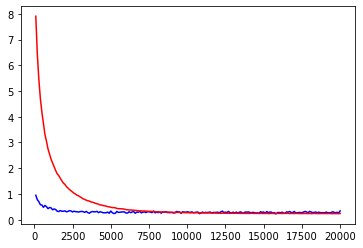

In [17]:
# Plot losses
plt.plot(vlosses[:,0],vlosses[:,1],'b')
plt.plot(tlosses[:,0],tlosses[:,1],'r')
plt.show()

In [ ]:
np.save("CVAE02.npy", vlosses)

In [18]:
n_params = 0
for p in model.parameters():
    n_params += np.prod(p.shape)

print("Parámeters: {0:,}".format(n_params)) 

Parámeters: 1,754,181


In [ ]:
bl = np.load("CVAE02.npy")

In [ ]:
np.min(bl)